In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from io import open
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import time
from scipy.stats import gaussian_kde
import scipy.stats as stats

In [2]:
# To import dataset and time_series_models succesful,
# here need to set correct path
import sys
import os
current_dir = os.path.dirname(os.path.abspath(''))
parent_dir = os.path.dirname(current_dir)

# here add current path. Please check the value of current_dir and parent_dir
sys.path.append(current_dir)

In [3]:
from dataset import N2O_synthetic_dataset, plot_features
# from time_series_models_hiddentransfer import LSTMSeq2Seq, GRUSeq2Seq, GRUSeq2SeqWithAttention, TimeSeriesModel, N2OGRU_multitask, RecoGRU_multitask

In [4]:
from time_series_models import GRUSeq2SeqWithAttention, TimeSeriesModel, SequenceDataset

In [5]:
import kgml_lib

In [6]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [7]:
# define functions from kgml_lib
Z_norm = kgml_lib.Z_norm 
Z_norm_reverse = kgml_lib.Z_norm_reverse

In [8]:
root_dir = 'E:/PyKGML/deposit_code_v2/'
# data_path = root_dir +  'processed_data/N2O_data/'
output_path = root_dir + 'test_results/'
input_data = 'input16_output5_pretrain_18yr.sav' #'input16_output5_pretrain_18yr_unscaled.sav'

data_path = root_dir +  'processed_data/N2O_data/' + input_data
output_path = root_dir + 'test_results/'
if not os.path.exists(output_path):
    os.mkdir(output_path)

# pretrained_model = "recotest_v11_exp4.sav_step1"
# output_model = "recotest_v11_exp4_sample.sav_step2"
# synthetic_data = "sys_data2.sav"

dataset = N2O_synthetic_dataset(data_path=data_path, scaler_path=None, out_path=output_path)
dataset.load_data()
dataset.prepare_data()

Scalers of the dataset are not provided, will implement normalization in the step of prepare_data()
data size is  torch.Size([6570, 1980, 21])
Inputs include  ['FERTZR_N', 'RADN', 'TMAX_AIR', 'TMIN_AIR', 'HMAX_AIR', 'HMIN_AIR', 'WIND', 'PRECN', 'PDOY', 'PLANTT', 'TBKDS', 'TCSAND', 'TCSILT', 'TPH', 'TCEC', 'TSOC']
Outputs include  ['N2O_FLUX', 'CO2_FLUX', 'WTR_3', 'NH4_3', 'NO3_3']


In [9]:
dataset.X.shape

torch.Size([6570, 1980, 16])

In [10]:
X = dataset.X 
X = torch.transpose(X,1, 0)  #[1980, 365*18, 16]
Y = dataset.Y 
Y = torch.transpose(Y,1, 0) #[1980, 365*18, 5]
# N2O = Y[:,:,-5:-4]
# print(N2O.size())
y_scaler = dataset.Yscaler

In [11]:
X.shape, Y.shape, y_scaler.shape

(torch.Size([1980, 6570, 16]), torch.Size([1980, 6570, 5]), (5, 2))

In [12]:
input_features = ['FERTZR_N', 'RADN', 'TMAX_AIR', 'TMIN_AIR', 'HMAX_AIR', 'HMIN_AIR', 'WIND', 'PRECN', 'PDOY', 'PLANTT', 'TBKDS', 'TCSAND', 'TCSILT', 'TPH', 'TCEC', 'TSOC']
output_features = ['N2O_FLUX', 'CO2_FLUX', 'WTR_3', 'NH4_3', 'NO3_3']

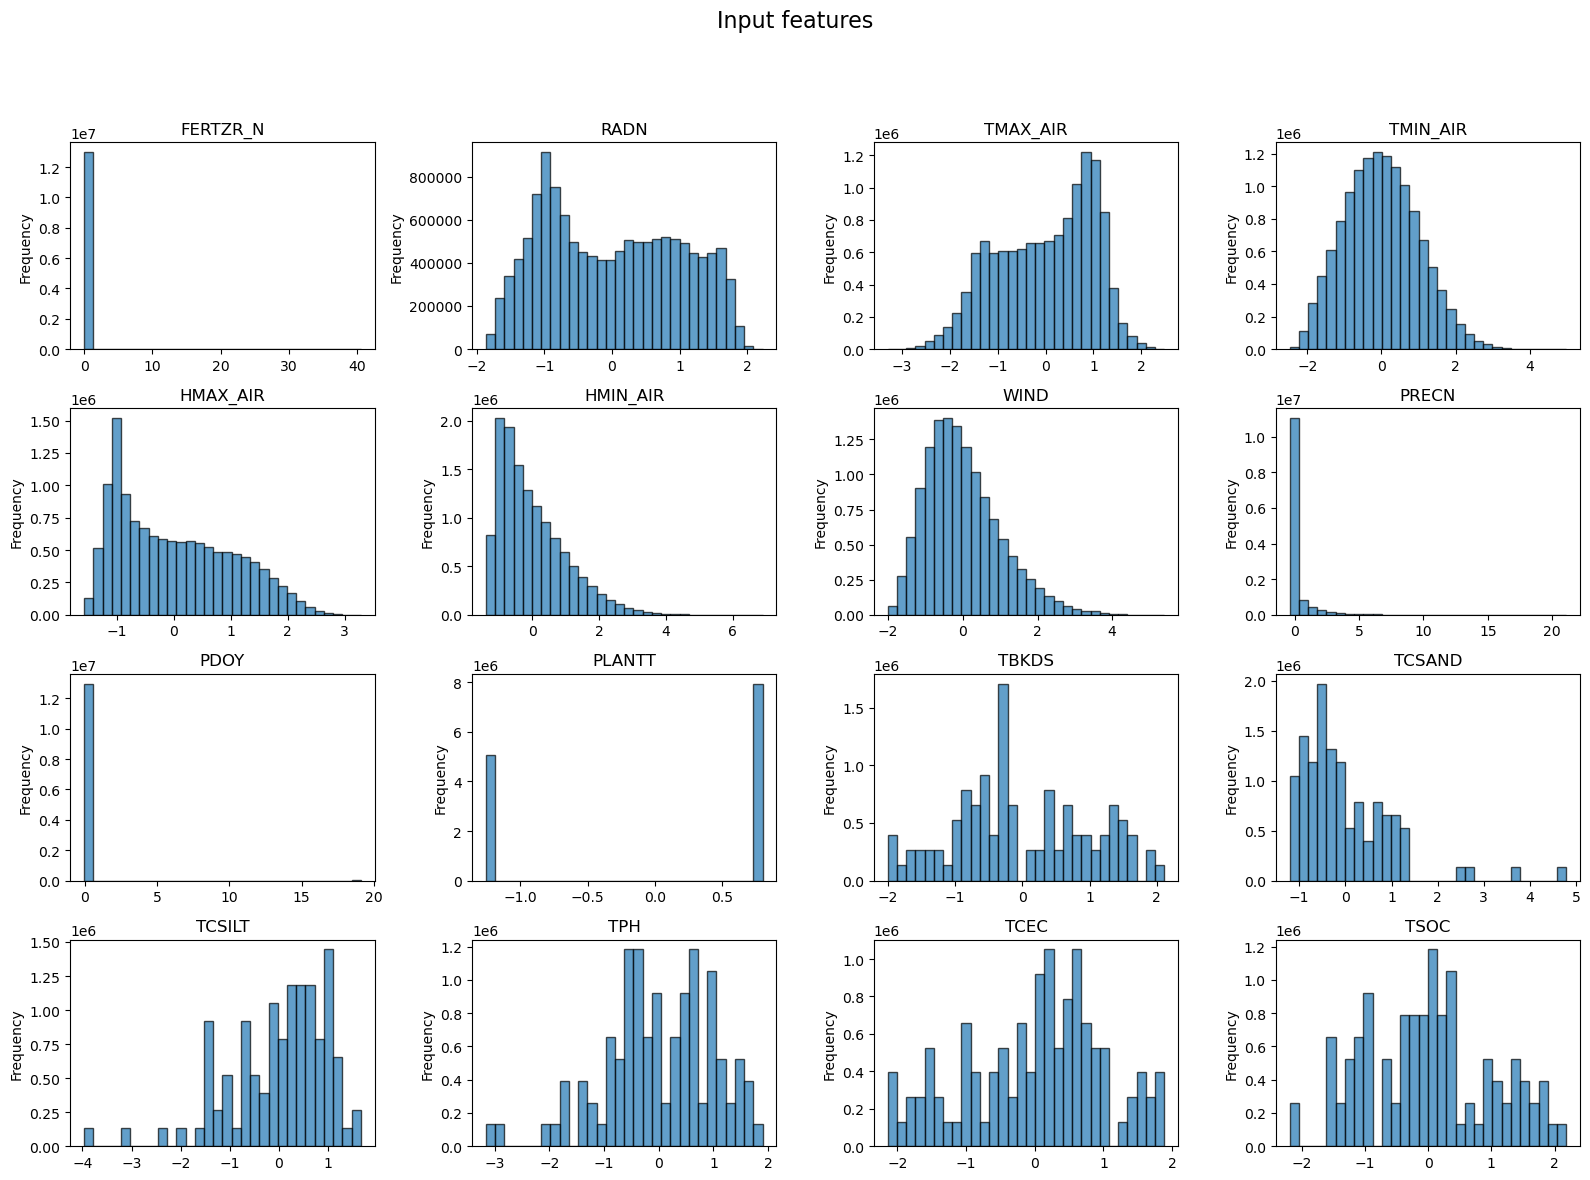

In [11]:
feature_len = len(input_features)
features = input_features
values = X.reshape(-1, feature_len)
sub_title = "Input features"
plot_features(values, feature_len, features, sub_title)

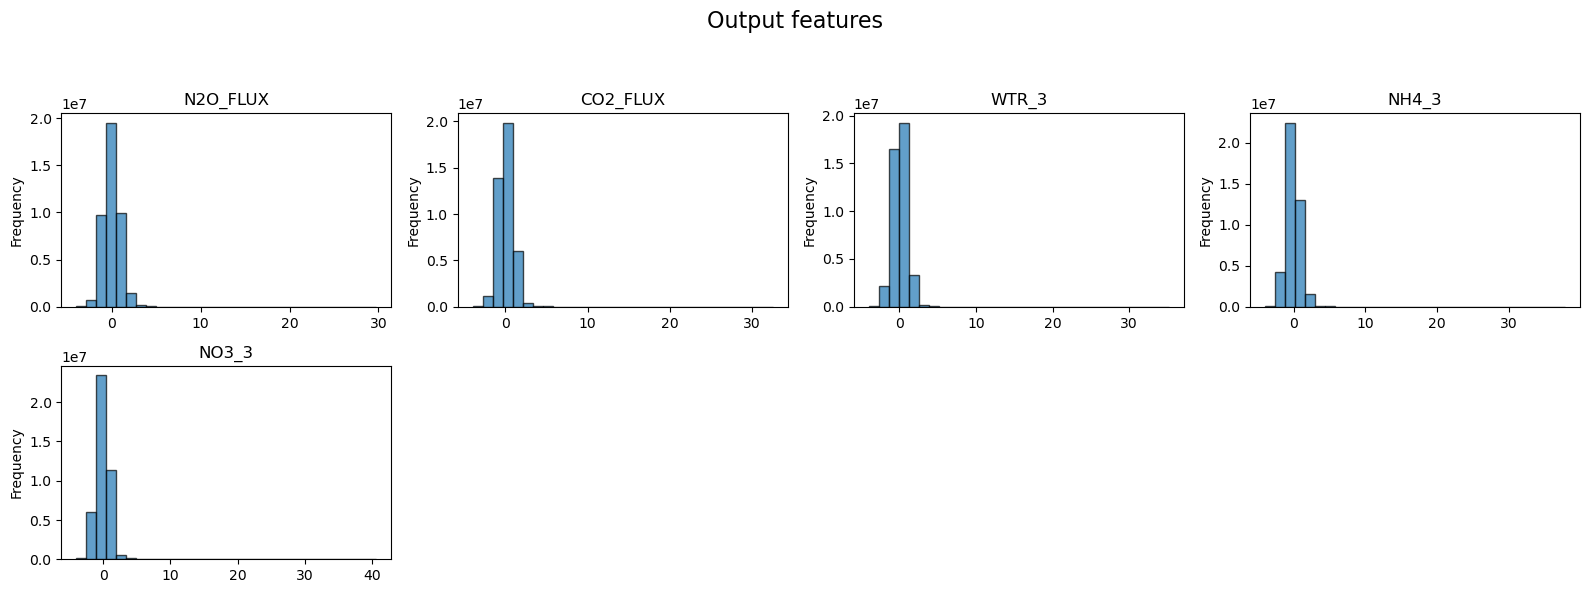

In [12]:
feature_len = len(output_features)
features = output_features
values = X.reshape(-1, feature_len)
sub_title = "Output features"
plot_features(values, feature_len, features, sub_title)

In [19]:
n2o_pretrain_file = data_path + 'n2o_pretrain_data.sav'
torch.save({'X': X,
            'Y': Y,
            'y_scaler': y_scaler,
            'input_features':input_features,
            'output_features': output_features}, n2o_pretrain_file)

In [20]:
num_input_features = 16
num_output_features = 5

input_dim = num_input_features
hidden_dim = 128
num_layers = 5
output_dim = num_output_features
dropout=0.2

In [21]:
# Choose one of the models below:
#model = LSTMSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)
# model = GRUSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)

# model = EnhancedGRUModel(input_dim, hidden_dim, num_layers, output_dim)

# model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim)

# model = N2OGRU_multitask(input_dim, hidden_dim, num_layers, output_dim1, output_dim2, dropout)
# model.train_test_split(X, Y, total_sites, total_years, batch_size, split_method = 'temporal', year_splitting=False)

In [22]:
X.shape, Y.shape, y_scaler.shape

(torch.Size([1980, 6570, 16]), torch.Size([1980, 6570, 5]), (5, 2))

In [23]:
total_sites = X.shape[0]
total_years = int(X.shape[1]/365)
print(total_sites, total_years)

batch_size=64
model.train_test_split(X, Y, total_years, batch_size)

1980 18


In [24]:
learning_rate = 0.001
step_size = 20
max_epoch = 60
loss_function = nn.L1Loss()

# model.train_model(train_loader, test_loader, LR= learning_rate, step_size=20, gamma=0.8, maxepoch=60)
model.train_model(loss_fun=loss_function, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/60 | LR: 0.001000, Train Loss: 0.2626, Test Loss: 0.2253
Epoch 2/60 | LR: 0.001000, Train Loss: 0.1834, Test Loss: 0.2344
Epoch 3/60 | LR: 0.001000, Train Loss: 0.1616, Test Loss: 0.2226
Epoch 4/60 | LR: 0.001000, Train Loss: 0.1486, Test Loss: 0.2030
Epoch 5/60 | LR: 0.001000, Train Loss: 0.1384, Test Loss: 0.2031
Epoch 6/60 | LR: 0.001000, Train Loss: 0.1323, Test Loss: 0.1973
Epoch 7/60 | LR: 0.001000, Train Loss: 0.1265, Test Loss: 0.2027
Epoch 8/60 | LR: 0.001000, Train Loss: 0.1220, Test Loss: 0.1985
Epoch 9/60 | LR: 0.001000, Train Loss: 0.1186, Test Loss: 0.1987
Epoch 10/60 | LR: 0.001000, Train Loss: 0.1158, Test Loss: 0.1971
Epoch 11/60 | LR: 0.001000, Train Loss: 0.1127, Test Loss: 0.1913
Epoch 12/60 | LR: 0.001000, Train Loss: 0.1105, Test Loss: 0.1933
Epoch 13/60 | LR: 0.001000, Train Loss: 0.1085, Test Loss: 0.1974
Epoch 14/60 | LR: 0.001000, Train Loss: 0.1069, Test Loss: 0.1945
Epoch 15/60 | LR: 0.001000, Train Loss: 0.1049, Test Loss: 0.1975
Epoch 16/60 | LR: 0

In [25]:
model.test()

Test Loss: 0.1869


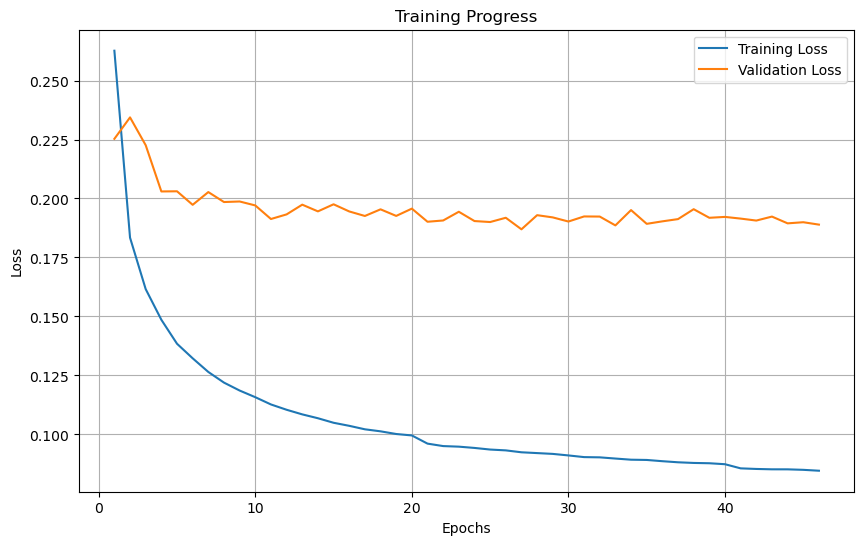

In [26]:
model.plot_training_curves()

In [27]:
output_feature_name = ['N2O_FLUX', 'CO2_FLUX', 'WTR_3', 'NH4_3', 'NO3_3']
model.get_R2_score(y_scaler, output_feature_name)

Feature N2O_FLUX R2 Score is: 0.6868441730636696
Feature CO2_FLUX R2 Score is: 0.959877562543755
Feature WTR_3 R2 Score is: 0.8501634245676287
Feature NH4_3 R2 Score is: 0.9389775472082821
Feature NO3_3 R2 Score is: 0.8212231430434024


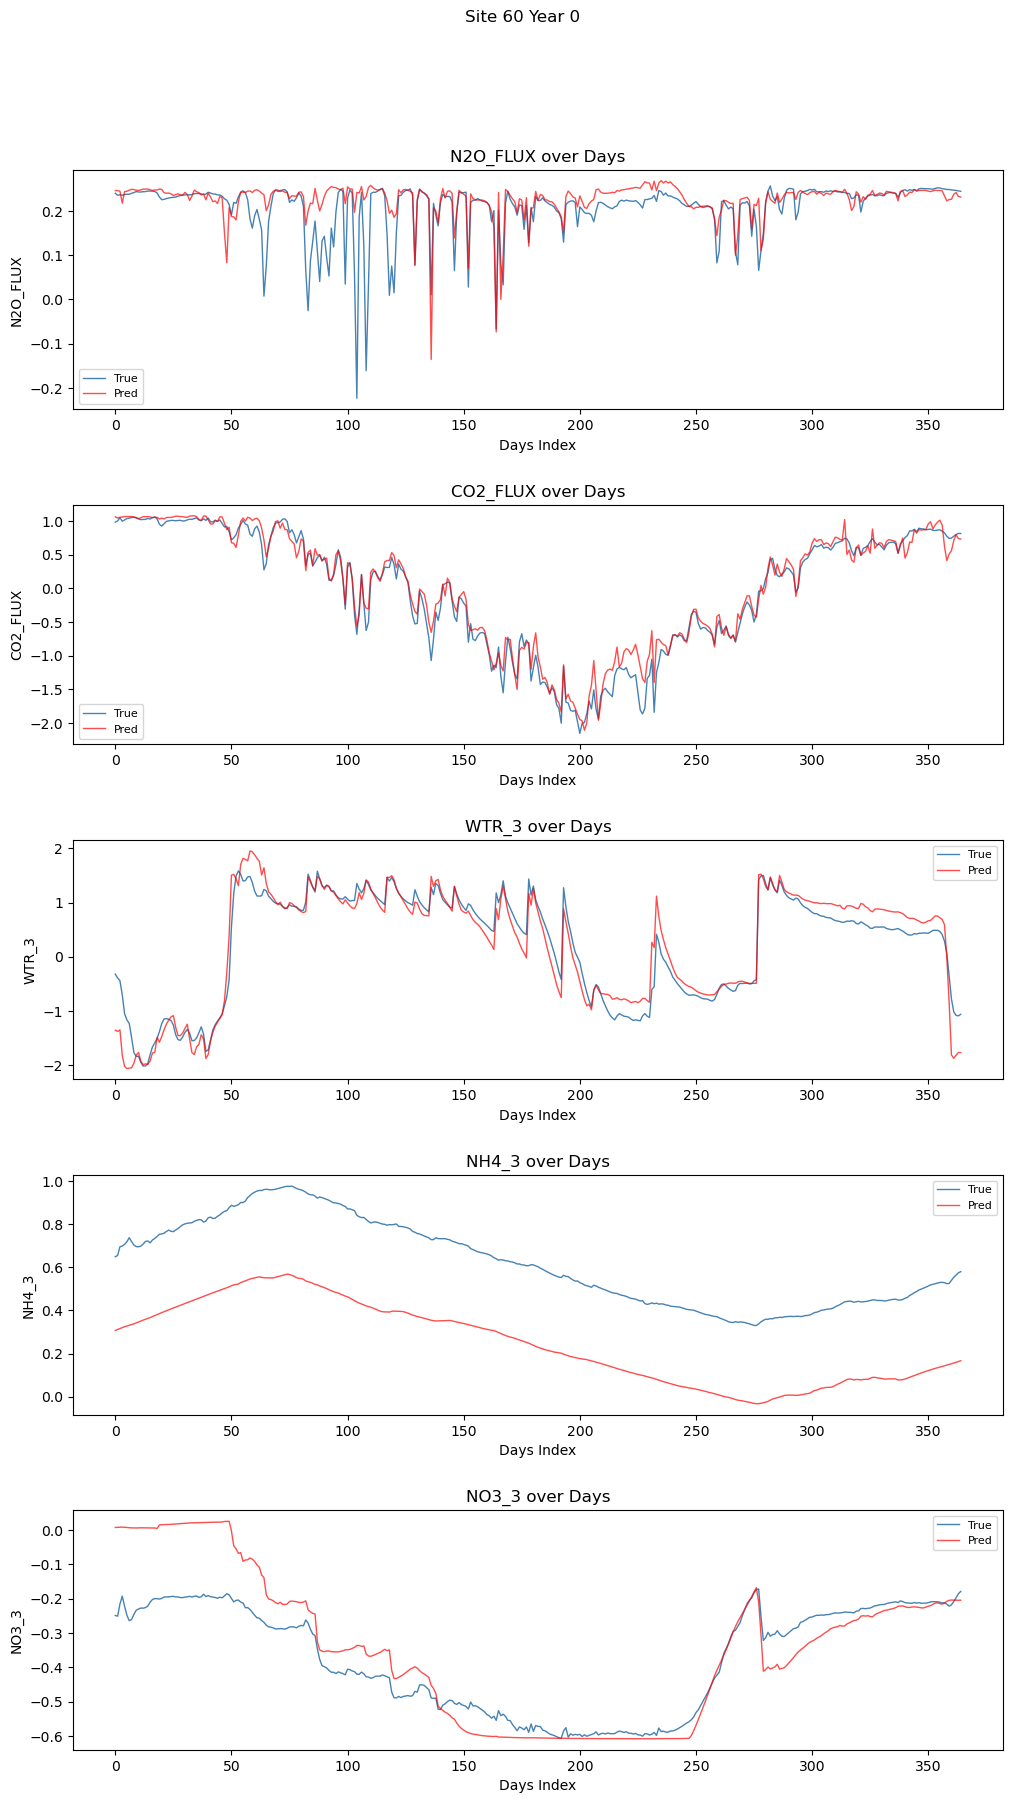

In [28]:
model.Vis_plot_prediction_result_time_series(y_scaler, output_feature_name, site=60, year=0)

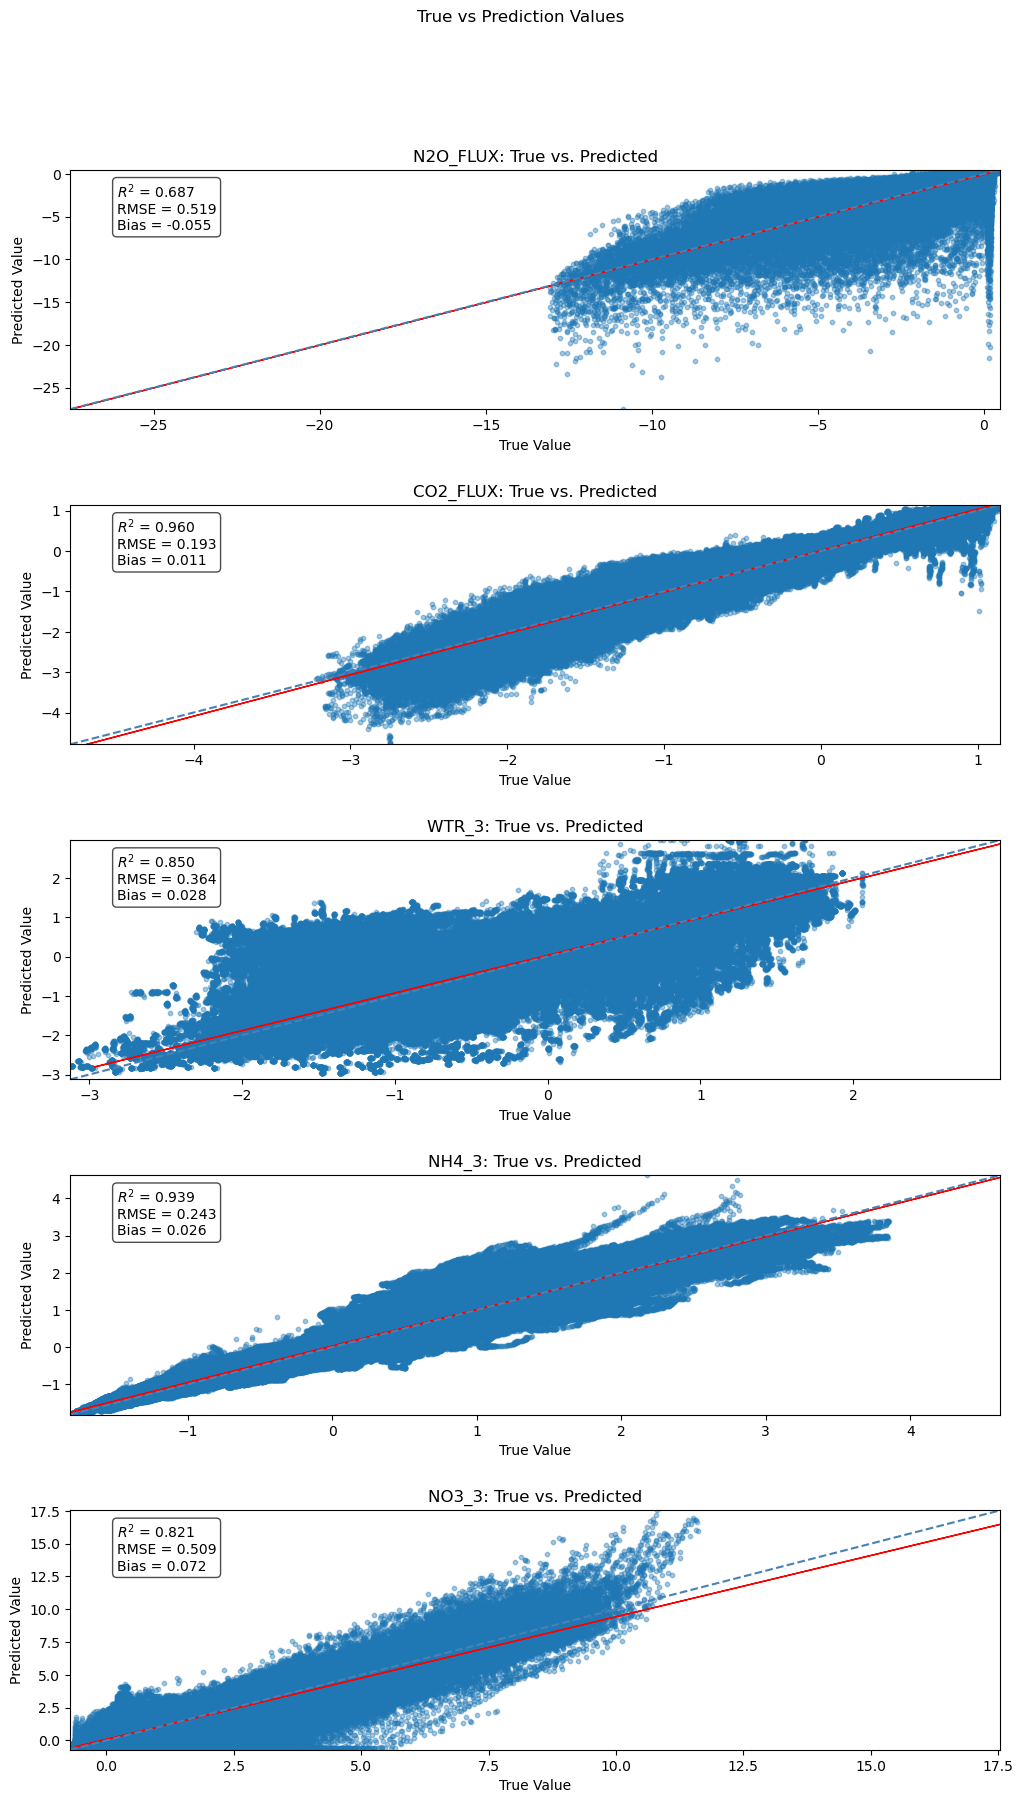

In [29]:
model.Vis_scatter_prediction_result(y_scaler, output_feature_name)